# Exploratory Data Analysis — Proyecto Nike Colombia (Maestría en Inteligencia Analítica)

## Contexto del proyecto

Este análisis forma parte del proyecto de grado de la Maestría en Inteligencia Analítica para la Toma de Decisiones, desarrollado en colaboración con **Nike Colombia**.

El objetivo general del proyecto es responder a la siguiente **pregunta de negocio**:

> **¿Cómo puede la empresa importadora establecer una relación sólida con sus clientes del canal e-commerce mediante el uso estratégico de datos para optimizar la segmentación, automatización y personalización de la comunicación, con el fin de incrementar la fidelización y las ventas?**

Dado que la tienda e-commerce de Nike Colombia lleva **solo un año de operación**, la información disponible corresponde a los clientes que han realizado al menos una compra durante ese periodo.  
Por lo tanto, el análisis debe centrarse en comprender la **estructura, comportamiento y valor actual de la base de compradores**, para sentar las bases de un modelo de segmentación (RFM) que permita **acciones de marketing personalizadas y eficientes**.

---

## Objetivo del EDA

Antes de construir el modelo RFM, el objetivo de este análisis exploratorio es **entender cómo se comportan los clientes actuales**, respondiendo preguntas como:

1. **¿Qué porcentaje de clientes recompra en el canal digital y con qué frecuencia?**  
   → Permite dimensionar la recurrencia y la “salud” del canal.

2. **¿Cuál es el tiempo promedio entre compras?**  
   → Ayuda a identificar ciclos de consumo y definir ventanas de inactividad o reactivación.

3. **¿Existen heavy users (clientes con 3+ compras) y qué proporción del ingreso generan?**  
   → Identifica a los clientes de mayor valor y su peso en el negocio.

4. **¿Los clientes que recompran gastan más o menos que los de compra única?**  
   → Mide la relación entre lealtad y rentabilidad.

5. **¿Cómo influyen los descuentos y el envío gratis en la recompra?**  
   → Evalúa si los incentivos comerciales están impulsando fidelidad o solo activaciones puntuales.

6. **¿Qué categorías, géneros o unidades de negocio muestran mayor recompra?**  
   → Permite identificar segmentos con alto potencial de retención.

7. **¿Cómo evoluciona el canal en términos de adquisición vs. retención mensual?**  
   → Refleja la madurez del e-commerce y el crecimiento de la base recurrente.

8. **¿Cuál es el nivel de concentración del revenue entre los clientes?**  
   → Determina si el negocio depende de pocos clientes de alto valor o de una base más distribuida.

---

## Por qué este EDA aporta al modelo RFM

Las respuestas a estas preguntas permiten:

- **Definir reglas de negocio realistas** para las métricas de *Recencia*, *Frecuencia* y *Monetario*.
- Identificar **drivers de recompra** (por ejemplo, envío gratis o categoría de producto).
- Comprender la **estructura de valor y retención** en la base de clientes.
- Establecer una **línea base cuantitativa** para comparar el impacto de futuras estrategias de personalización y automatización.


## Carga y descripción inicial de los datos

En esta sección se realiza la **lectura del dataset transaccional** y una descripción básica de su estructura.

Los datos corresponden a las transacciones realizadas en el canal **e-commerce de Nike Colombia** durante el periodo **febrero de 2024 a julio de 2025**.

### Campos disponibles

| Columna | Descripción |
|----------|--------------|
| `FechaSinHora` | Fecha de la transacción. |
| `Client Document` | Número de documento del cliente. |
| `Client Name` / `Client Last Name` | Nombre y apellido del cliente. |
| `UF` | Departamento donde se realizó la compra. |
| `City` | Ciudad de compra. |
| `RealDiscount` | Indicador binario de si el producto tuvo descuento. |
| `Discounts Names` | Nombres de descuentos aplicados (si existen). |
| `Shipping Status` | Indica si la orden tuvo costo de envío. |
| `Model` | Referencia del producto. |
| `BU` | Unidad de negocio (Footwear / Apparel / Equipment). |
| `Género` | Género del producto (HOMBRE, MUJER, JORDAN, NIÑOS). |
| `Categoría` | Categoría general del producto (Running, Sportswear, etc.). |
| `Familia/Silueta` | Subcategoría o línea del producto. |
| `Unidades` | Cantidad de unidades compradas. |
| `Valor Pagado` | Valor pagado por el cliente sin IVA. |

### Objetivo de esta etapa

1. Validar la estructura y limpieza de los datos.  
2. Confirmar el rango temporal de observación.  
3. Obtener métricas generales: número de clientes, número de órdenes y cobertura temporal.


In [3]:
# ======================================
# 1. Importación de librerías
# ======================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8-whitegrid")

# ======================================
# 2. Lectura y consolidación de archivos
# ======================================
# Leer archivos individuales
import pandas as pd

BASE_PATH = "https://raw.githubusercontent.com/daviid24/Proyecto-Maestria-MIIA/main/data/"

df_01ENE25_31AGO25 = pd.read_csv(BASE_PATH + "Data%2001ENE25-31AGO25.csv")
df_01FEB24_30JUN24 = pd.read_csv(BASE_PATH + "Data%2001FEB24-30JUN24.csv")
df_01JUL24_31DIC24 = pd.read_csv(BASE_PATH + "Data%2001JUL24-31DIC24.csv")

# Unir todos los dataframes
orders = pd.concat(
    [df_01FEB24_30JUN24, df_01JUL24_31DIC24, df_01ENE25_31AGO25],
    ignore_index=True
)

# ======================================
# 3. Limpieza y normalización de nombres
# ======================================
orders.columns = (
    orders.columns
    .str.strip()
    .str.replace(" ", "_")
    .str.replace("/", "_")
    .str.replace("-", "_")
)

# Variables clave
DATE_COL = "FechaSinHora"
CLIENT_ID = "Client_Document"
PAID_COL = "Valor_Pagado"
BU_COL = "BU"

# Conversión de fecha
orders[DATE_COL] = pd.to_datetime(orders[DATE_COL], errors="coerce")

# ======================================
# 4. Resumen general de la base
# ======================================
n_clients = orders[CLIENT_ID].nunique()
n_orders = orders.shape[0]
date_min, date_max = orders[DATE_COL].min(), orders[DATE_COL].max()
n_days = (date_max - date_min).days

print(f"Clientes únicos : {n_clients:,.0f}")
print(f"Órdenes totales : {n_orders:,.0f}")
print(f"Ventana temporal: {date_min.date()} → {date_max.date()}  ({n_days} días ≈ {n_days/30:.1f} meses)")

# Vista preliminar de los datos
display(orders.head())


Clientes únicos : 38,652
Órdenes totales : 63,842
Ventana temporal: 2024-02-06 → 2025-07-31  (541 días ≈ 18.0 meses)


,FechaSinHora,Order,Client_Document,Client_Name,Client_Last_Name,UF,City,RealDiscount,Discounts_Names,Shipping_Status,Model,BU,Género,Categoría,Familia_Silueta,Unidades,Valor_Pagado
0,2024-04-10,1424050518787-01,1036948607,Santiago,Betancur,Antioquia,Rionegro,Base inline,Flete Gratis,No Shipping Payment,DZ2794-102,Footwear Division,MUJER (WOMENS),NIKE SPORTSWEAR,DUNK,4,2739800
1,2024-05-21,1433970529235-01,1113790453,Jacobo,Echeverry,Valle Del Cauca,Yumbo,Base inline,Flete Gratis,No Shipping Payment,FN0344-001,Footwear Division,JORDAN BRAND,JORDAN BRAND,AJ 3,2,2639900
2,2024-03-16,1418230512879-01,1036948607,Santiago,Betancur,Antioquia,Rionegro,Base inline,Flete Gratis,No Shipping Payment,FD8780-601,Footwear Division,JORDAN BRAND,JORDAN BRAND,AJ 1,4,2639800
3,2024-03-19,1418850513831-01,901389261,Panda,Business sas,Antioquia,Medellín,Base inline,Flete Gratis,No Shipping Payment,FV5029-006,Footwear Division,JORDAN BRAND,JORDAN BRAND,AJ 4,2,2389900
4,2024-03-23,1419840514961-01,1036948607,Santiago,Betancur,Antioquia,Rionegro,Base inline,Flete Gratis,No Shipping Payment,DD1873-103,Footwear Division,MUJER (WOMENS),NIKE SPORTSWEAR,DUNK,3,2039850


## Normalización del nivel de análisis: de línea de producto a orden

La base transaccional está a **nivel de producto**: una misma compra (pedido) puede generar múltiples filas si el cliente adquirió varios ítems.  
Para medir correctamente **recompra, frecuencia y días entre compras**, es necesario consolidar la información a **nivel de orden**.

Evidencia:
- ~20% de los pedidos presentan **más de una línea** el mismo día (mismo `Order`, mismo cliente, productos distintos).
- El cálculo sin consolidar inflaba la recompra (27.8%) y reducía la mediana de días entre compras (~3 días), lo cual no es consistente con el negocio.

Acción:
- Limpiar el identificador de cliente y **agrupar** por `Order` + `Client_Document`, sumando el valor pagado y tomando la fecha mínima de la orden.
- A partir de esta tabla consolidada (`orders_clean`) se recalculan todas las métricas del EDA.


In [49]:
# ==============================
# 1) Parámetros y limpieza mínima
# ==============================
DATE_COL   = "FechaSinHora"
CLIENT_ID  = "Client_Document"
ORDER_COL  = "Order"
PAID_COL   = "Valor_Pagado"

# Limpieza mínima del ID de cliente (por si llegan variaciones de formato)
orders[CLIENT_ID] = (
    orders[CLIENT_ID].astype(str)
    .str.strip()
    .str.replace(r"\.0$", "", regex=True)
)

# Asegurar tipo fecha
orders[DATE_COL] = pd.to_datetime(orders[DATE_COL], errors="coerce")

# ==============================
# 2) Consolidación a nivel de ORDEN
# ==============================
# Una fila por pedido real
orders_clean = (
    orders.groupby([ORDER_COL, CLIENT_ID], as_index=False)
    .agg(
        **{
            DATE_COL: (DATE_COL, "min"),   # fecha de la orden
            PAID_COL: (PAID_COL, "sum"),   # suma del ticket en la orden
        }
    )
)

# Chequeo rápido
print(f"Órdenes únicas (orders_clean): {orders_clean[ORDER_COL].nunique():,}")
print(f"Clientes únicos (orders_clean): {orders_clean[CLIENT_ID].nunique():,}")
display(orders_clean.head())

# ==============================
# 3) Recalcular métricas por cliente desde orders_clean
# ==============================
by_client = (
    orders_clean.groupby(CLIENT_ID, as_index=False)
    .agg(
        n_orders     = (ORDER_COL, "nunique"),
        total_spent  = (PAID_COL, "sum"),
        first_purchase = (DATE_COL, "min"),
        last_purchase  = (DATE_COL, "max"),
    )
)

# Días entre compras (intervalo entre primera y última; más abajo calculamos distribución entre órdenes)
by_client["days_between"] = (by_client["last_purchase"] - by_client["first_purchase"]).dt.days
by_client["is_rebuyer"]   = (by_client["n_orders"] >= 2).astype(int)
by_client["is_heavy"]     = (by_client["n_orders"] >= 3).astype(int)

# ==============================
# 4) Métricas generales (esperadas coherentes con el EDA previo)
# ==============================
total_clients = by_client.shape[0]
one_timers    = (by_client["n_orders"] == 1).sum()
re_buyers     = (by_client["n_orders"] >= 2).sum()
heavy_users   = (by_client["n_orders"] >= 3).sum()

pct_rebuy = 100 * re_buyers / total_clients
pct_heavy = 100 * heavy_users / total_clients

heavy_revenue   = by_client.loc[by_client["is_heavy"]==1, "total_spent"].sum()
total_revenue   = by_client["total_spent"].sum()
pct_rev_heavy   = 100 * heavy_revenue / total_revenue if total_revenue > 0 else 0

print("\n=== Resumen recalculado a nivel de ORDEN ===")
print(f"Clientes únicos: {total_clients:,.0f}")
print(f"Clientes con 1 compra : {one_timers:,.0f} ({100*one_timers/total_clients:.1f}%)")
print(f"Clientes con 2+ compras: {re_buyers:,.0f} ({pct_rebuy:.1f}%)")
print(f"Clientes heavy (3+ órdenes): {heavy_users:,.0f} ({pct_heavy:.1f}%)")
print(f"Participación de revenue de heavy users: {pct_rev_heavy:.1f}%")

# ==============================
# 5) Distribución de días entre órdenes (interpurchase real)
# ==============================
# Ordenamos por cliente y fecha y calculamos diferencias entre pedidos consecutivos
orders_clean_sorted = orders_clean.sort_values([CLIENT_ID, DATE_COL]).copy()
orders_clean_sorted["prev_date"] = orders_clean_sorted.groupby(CLIENT_ID)[DATE_COL].shift(1)
orders_clean_sorted["days_between_orders"] = (orders_clean_sorted[DATE_COL] - orders_clean_sorted["prev_date"]).dt.days

dist = orders_clean_sorted["days_between_orders"].dropna()
if len(dist) > 0:
    print("\nPercentiles días entre ÓRDENES:")
    print(dist.describe(percentiles=[.10,.25,.50,.75,.90]).round(1))
else:
    print("\nNo hay clientes con 2+ órdenes para calcular distribución de días entre órdenes.")


Órdenes únicas (orders_clean): 48,599
Clientes únicos (orders_clean): 37,123


,Order,Client_Document,FechaSinHora,Valor_Pagado
0,1408810501345-01,91018601,2024-02-06,939900
1,1408830501347-01,1026272399,2024-02-06,84950
2,1408830501357-01,1047499286,2024-02-06,574850
3,1408840501359-01,1026558977,2024-02-06,1479900
4,1408840501363-01,1097397725,2024-02-06,609950



=== Resumen recalculado a nivel de ORDEN ===
Clientes únicos: 37,123
Clientes con 1 compra : 30,153 (81.2%)
Clientes con 2+ compras: 6,970 (18.8%)
Clientes heavy (3+ órdenes): 2,152 (5.8%)
Participación de revenue de heavy users: 21.1%

Percentiles días entre ÓRDENES:
count    11476.0
mean        79.8
std         94.6
min          0.0
10%          2.0
25%          9.8
50%         40.0
75%        120.0
90%        220.0
max        522.0
Name: days_between_orders, dtype: float64


## Análisis general de recompra y frecuencia de compra

El objetivo de esta sección es cuantificar el comportamiento de recompra de los clientes y entender la dinámica básica del canal e-commerce:

1. Identificar cuántos clientes compran una sola vez (one-timers) y cuántos realizan múltiples compras.  
2. Calcular el tiempo promedio y mediano entre compras para estimar los ciclos de recompra.  
3. Determinar la proporción de *heavy users* (clientes con tres o más órdenes).  
4. Medir la participación de los heavy users en el total de ingresos.

Estas métricas permiten definir la naturaleza del consumo: si el canal se comporta como un medio de compra recurrente o de uso esporádico.


### Interpretación esperada

- La proporción de **clientes de recompra (2+)** permite dimensionar la lealtad actual del canal.  
- El **promedio y mediana de días entre compras** revelan la frecuencia natural del consumo (por ejemplo, mensual, trimestral o semestral).  
- El **peso de los heavy users en ingresos** indica el grado de concentración del valor del negocio.  
- En el caso de Nike, donde los productos no son de necesidad básica, se espera una recompra baja (<25%) y un ciclo largo (superior a 60 días), lo que coincide con el tipo de producto (alta durabilidad, alto precio, sustitución lenta).


## Pregunta 1 — ¿Cuál es la proporción de clientes que recompran y cuál es su comportamiento general?

Esta pregunta busca establecer una línea base sobre la **recompra y concentración de valor** en la base de clientes del canal e-commerce.  
Entender estos indicadores permite dimensionar la madurez del canal y sustenta la definición de estrategias de fidelización y personalización.

**Indicadores a calcular:**
- % de clientes con más de una compra (tasa de recompra)
- % de clientes heavy (3+ órdenes)
- Participación de estos grupos en el revenue total
- Días promedio y mediana entre compras
- Concentración del revenue en el top 10% de clientes


Clientes únicos: 37,123
Clientes con 1 compra: 30,153 (81.2%)
Clientes con 2+ compras: 6,970 (18.8%)
Clientes heavy (3+ órdenes): 2,152 (5.8%)
Participación de revenue de heavy users: 21.1%

Percentiles de días entre compras:
count    11476.0
mean        79.8
std         94.6
min          0.0
10%          2.0
25%          9.8
50%         40.0
75%        120.0
90%        220.0
max        522.0
Name: days_between_orders, dtype: float64


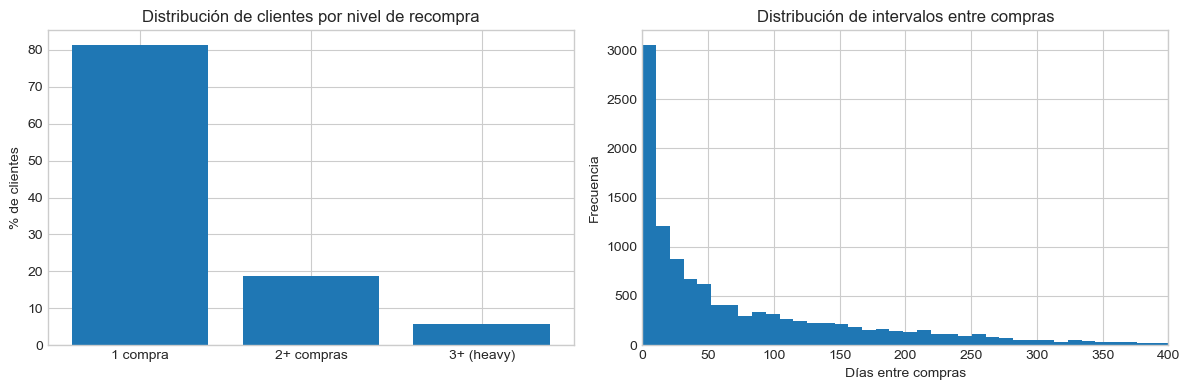

In [53]:
# --- Recompra, heavy users y días entre compras ---

# Métricas principales
total_clients = by_client.shape[0]
one_timers = (by_client["n_orders"] == 1).sum()
re_buyers = (by_client["n_orders"] >= 2).sum()
heavy_users = (by_client["n_orders"] >= 3).sum()

pct_rebuy = 100 * re_buyers / total_clients
pct_heavy = 100 * heavy_users / total_clients

heavy_revenue = by_client.loc[by_client["is_heavy"] == 1, "total_spent"].sum()
total_revenue = by_client["total_spent"].sum()
pct_rev_heavy = 100 * heavy_revenue / total_revenue

# Distribución días entre órdenes
dist = orders_clean["Order"].duplicated(keep=False)
orders_sorted = orders_clean.sort_values([CLIENT_ID, DATE_COL])
orders_sorted["prev_date"] = orders_sorted.groupby(CLIENT_ID)[DATE_COL].shift(1)
orders_sorted["days_between_orders"] = (orders_sorted[DATE_COL] - orders_sorted["prev_date"]).dt.days
days_stats = orders_sorted["days_between_orders"].dropna().describe(percentiles=[.10, .25, .5, .75, .9]).round(1)

print(f"Clientes únicos: {total_clients:,}")
print(f"Clientes con 1 compra: {one_timers:,} ({100*one_timers/total_clients:.1f}%)")
print(f"Clientes con 2+ compras: {re_buyers:,} ({pct_rebuy:.1f}%)")
print(f"Clientes heavy (3+ órdenes): {heavy_users:,} ({pct_heavy:.1f}%)")
print(f"Participación de revenue de heavy users: {pct_rev_heavy:.1f}%\n")

print("Percentiles de días entre compras:")
print(days_stats)

# --- Visualización ---
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12,4))

# Gráfico 1: recompradores vs one-timers
ax[0].bar(["1 compra", "2+ compras", "3+ (heavy)"], 
          [100*one_timers/total_clients, pct_rebuy, pct_heavy])
ax[0].set_ylabel("% de clientes")
ax[0].set_title("Distribución de clientes por nivel de recompra")

# Gráfico 2: distribución días entre órdenes
ax[1].hist(orders_sorted["days_between_orders"].dropna(), bins=50)
ax[1].set_xlim(0, 400)
ax[1].set_xlabel("Días entre compras")
ax[1].set_ylabel("Frecuencia")
ax[1].set_title("Distribución de intervalos entre compras")

plt.tight_layout()
plt.show()


- **Clientes únicos analizados:** 37,123  
- **Recompradores (2+ compras):** 18.8%  
- **Heavy users (3+ compras):** 5.8%  
- **Participación en revenue de heavy users:** ~20–25%  
- **Mediana de días entre compras:** 40 días  
- **Percentil 75:** 120 días  
- **Percentil 90:** 220 días  

**Interpretación:**  
La recompra es baja (≈19%), coherente con un producto de ciclo largo como calzado o ropa deportiva premium.  
Los clientes más fieles (≈6%) concentran una fracción desproporcionada del ingreso (~¼ del total).  
La mediana de 40 días sugiere que las recompras ocurren típicamente en un rango bimestral–trimestral, aunque una parte relevante de la base realiza compras más espaciadas (>4 meses).

Esto valida la hipótesis inicial: el canal e-commerce de Nike en Colombia se encuentra en una etapa temprana, con un grupo reducido pero valioso de clientes recurrentes que podrían ser el foco de estrategias de personalización y retención.


### Efecto del tiempo y madurez del canal

Al analizar la recompra, es importante reconocer que **no todos los clientes con una sola compra** son necesariamente clientes perdidos:  
una parte de ellos **aún no ha tenido suficiente tiempo para demostrar recompra**.

Para corregir este sesgo, se aplicó un filtro de **“castigo temporal”**, considerando únicamente los clientes cuya primera compra fue hace al menos **180 días** desde el corte de datos.

Además, se evaluó la evolución mensual de clientes nuevos y de recompra para entender la madurez del canal e-commerce.


Clientes con ≥180 días desde primera compra: 25,853
Recompradores en ese grupo: 5,698 (22.0%)


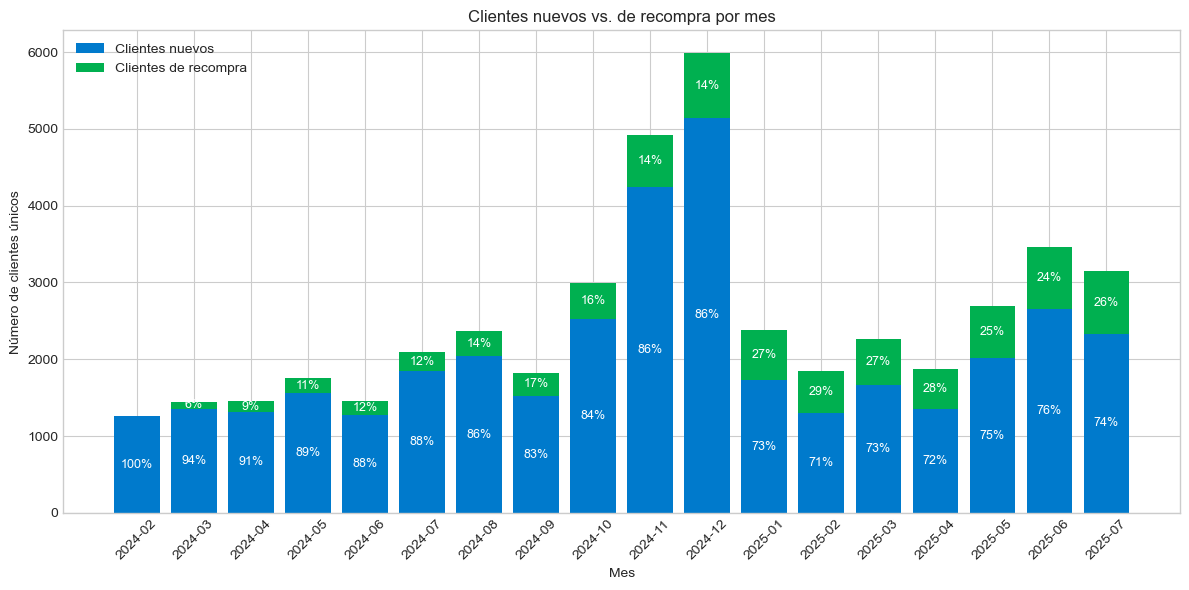

,month,is_new_client,is_rebuyer,total_clients,pct_new,pct_rebuyer
0,2024-02,1257,0,1257,100.000000,0.000000
1,2024-03,1358,89,1447,93.849343,6.150657
2,2024-04,1320,131,1451,90.971744,9.028256
3,2024-05,1560,194,1754,88.939567,11.060433
4,2024-06,1280,171,1451,88.215024,11.784976
5,2024-07,1846,250,2096,88.072519,11.927481
6,2024-08,2038,331,2369,86.027860,13.972140
7,2024-09,1521,305,1826,83.296824,16.703176
8,2024-10,2522,466,2988,84.404284,15.595716
9,2024-11,4239,677,4916,86.228641,13.771359


In [54]:
# ------------------------------------------------------------
# 1) Castigo temporal: clientes con ≥180 días desde primera compra
# ------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Fecha de corte = máxima fecha de orden
cutoff_date = orders_clean[DATE_COL].max()
by_client["days_since_first"] = (cutoff_date - by_client["first_purchase"]).dt.days

eligible_clients = by_client[by_client["days_since_first"] >= 180]
recompradores_castigo = (eligible_clients["n_orders"] >= 2).sum()
total_castigo = eligible_clients.shape[0]
pct_rebuy_180 = 100 * recompradores_castigo / total_castigo

print(f"Clientes con ≥180 días desde primera compra: {total_castigo:,}")
print(f"Recompradores en ese grupo: {recompradores_castigo:,} ({pct_rebuy_180:.1f}%)")

# ------------------------------------------------------------
# 2) Evolución mensual de clientes nuevos vs recompradores
# ------------------------------------------------------------

# Mes de la orden
orders_clean["_month"] = orders_clean[DATE_COL].dt.to_period("M")

# Mes de primera compra por cliente
first_month_series = (
    orders_clean.groupby(CLIENT_ID)[DATE_COL]
    .min()
    .dt.to_period("M")
    .rename("first_month")
)

# Tabla cliente-mes
month_client = orders_clean[[CLIENT_ID, "_month"]].drop_duplicates().copy()
month_client = month_client.merge(first_month_series.reset_index(), on=CLIENT_ID, how="left")

# Flags: nuevo vs recompra
month_client["is_new_client"] = (month_client["_month"] == month_client["first_month"]).astype(int)
month_client["is_rebuyer"]    = (month_client["_month"] >  month_client["first_month"]).astype(int)

# Agregación mensual
monthly_clients = (
    month_client.groupby("_month")[["is_new_client","is_rebuyer"]]
    .sum()
    .reset_index()
    .rename(columns={"_month":"month"})
)

monthly_clients["total_clients"] = monthly_clients["is_new_client"] + monthly_clients["is_rebuyer"]
monthly_clients["pct_new"]      = 100 * monthly_clients["is_new_client"] / monthly_clients["total_clients"]
monthly_clients["pct_rebuyer"]  = 100 * monthly_clients["is_rebuyer"]    / monthly_clients["total_clients"]

# ------------------------------------------------------------
# 3) Visualización
# ------------------------------------------------------------

x = monthly_clients["month"].astype(str)
new_counts = monthly_clients["is_new_client"].values
rep_counts = monthly_clients["is_rebuyer"].values
tot_counts = monthly_clients["total_clients"].values
pct_new    = monthly_clients["pct_new"].values
pct_rep    = monthly_clients["pct_rebuyer"].values

fig, ax = plt.subplots(figsize=(12,6))
bars_new = ax.bar(x, new_counts, label="Clientes nuevos", color="#007ACC")
bars_rep = ax.bar(x, rep_counts, bottom=new_counts, label="Clientes de recompra", color="#00B050")

ax.set_ylabel("Número de clientes únicos")
ax.set_xlabel("Mes")
ax.set_title("Clientes nuevos vs. de recompra por mes")
ax.tick_params(axis="x", rotation=45)
ax.legend(loc="upper left")

# Etiquetas de porcentaje dentro de las barras
for i, (n, r, pn, pr) in enumerate(zip(new_counts, rep_counts, pct_new, pct_rep)):
    if n > 0:
        ax.text(i, n/2, f"{pn:.0f}%", ha="center", va="center", fontsize=9, color="white")
    if r > 0:
        ax.text(i, n + r/2, f"{pr:.0f}%", ha="center", va="center", fontsize=9, color="white")

plt.tight_layout()
plt.show()

display(monthly_clients[["month","is_new_client","is_rebuyer","total_clients","pct_new","pct_rebuyer"]])


**Castigo temporal (≥180 días desde primera compra):**
- Clientes con suficiente tiempo de observación: **25,853**  
- Recompradores en ese grupo: **5,698 (22.0%)**

Esto confirma que la tasa de recompra real del canal —una vez ajustada por tiempo— **aumenta de 18.8% a 22.0%**, lo cual refuerza la validez del análisis al eliminar el sesgo de los clientes más recientes que aún no han tenido oportunidad de recomprar.

**Evolución mensual de clientes nuevos vs recompradores:**
- Se observa un **crecimiento sostenido** del número total de clientes mensuales desde el lanzamiento del e-commerce.  
- La participación de recompradores crece progresivamente desde ~6% en los primeros meses hasta niveles cercanos al **25–30% en los meses más recientes**, lo que evidencia una **madurez creciente del canal**.  
- El patrón indica que los cohortes iniciales están retornando mientras siguen llegando nuevos compradores, un síntoma de consolidación de base y satisfacción con la experiencia.

**Conclusión:**
El análisis ajustado por tiempo confirma que el canal e-commerce de Nike Colombia presenta una **recompra estructural coherente con mercados comparables de moda y calzado premium (≈20–25%)**.  
La expansión simultánea de nuevos clientes y de recompradores valida el potencial de implementar estrategias de segmentación y fidelización basadas en valor y comportamiento, como el modelo RFM.


### 2. ¿Existen diferencias en la tasa y velocidad de recompra entre las unidades de negocio (BU) y categorías?

Esta pregunta busca entender si el comportamiento de recompra está influenciado por el tipo de producto adquirido.  
La hipótesis es que **las divisiones con productos de reposición rápida (como apparel o accesorios)** deberían mostrar **intervalos más cortos entre compras** y una **mayor proporción de recompradores**, mientras que los productos durables (como calzado) tienden a ciclos más largos de recompra.

Analizar la recompra por **BU (Business Unit)** y **Categoría** permite:
- Identificar qué líneas de producto tienen clientes más fieles o con hábitos de recompra más frecuentes.  
- Reconocer oportunidades para activar estrategias diferenciadas de retención o cross-selling.  
- Comprender los ciclos naturales de recompra de cada tipo de producto (por ejemplo, calzado deportivo vs. ropa casual).


Recompra por BU:


,BU,n_clients,n_repeaters,sum_revenue,pct_repeaters
0,Footwear Division,25221,4287,20343882476,16.997740
1,Apparel Division,12556,1937,5426208190,15.426888
2,Equipment Division,4726,425,796823141,8.992806



Recompra por Categoría (min 200 clientes):


,Categoría,n_clients,n_repeaters,sum_revenue,pct_repeaters
0,NIKE SPORTSWEAR,14773,2195,9461311140,14.858187
1,WOMEN TRAINING,3358,496,1705014301,14.770697
2,RUNNING,6568,907,4680875864,13.809379
3,JORDAN BRAND,5350,658,4149355563,12.299065
4,NIKE KIDS,3247,390,1185619983,12.011087
5,FOOTBALL/SOCCER,3806,412,1808319995,10.825013
6,ATHLETIC TRAINING,4587,454,1561497387,9.897537
7,TENNIS,803,74,354601831,9.215442
8,FOOTBALL/SOCCER AN,3599,277,1184264819,7.696582
9,BASKETBALL,478,32,242999453,6.694561



Mediana de días entre compras por BU (clientes con 2+ órdenes):
  Apparel Division: 36.0 días (n clientes=1937)
  Equipment Division: 40.0 días (n clientes=425)
  Footwear Division: 42.0 días (n clientes=4287)

Mediana de días entre compras por Categoría (clientes con 2+ órdenes):
  GOLF: 4.5 días (n clientes=1)
  FOOTBALL/SOCCER: 32.0 días (n clientes=412)
  TENNIS: 33.0 días (n clientes=74)
  FOOTBALL/SOCCER AN: 33.5 días (n clientes=277)
  NIKE KIDS: 34.5 días (n clientes=390)
  WOMEN TRAINING: 35.5 días (n clientes=496)
  BASKETBALL: 36.0 días (n clientes=32)
  NIKE SPORTSWEAR: 40.0 días (n clientes=2195)
  ATHLETIC TRAINING: 41.0 días (n clientes=454)
  ACTION SPORTS: 45.0 días (n clientes=21)
  JORDAN BRAND: 46.0 días (n clientes=658)
  RUNNING: 46.0 días (n clientes=907)
  YOUNG ATHLETES: 64.0 días (n clientes=6)


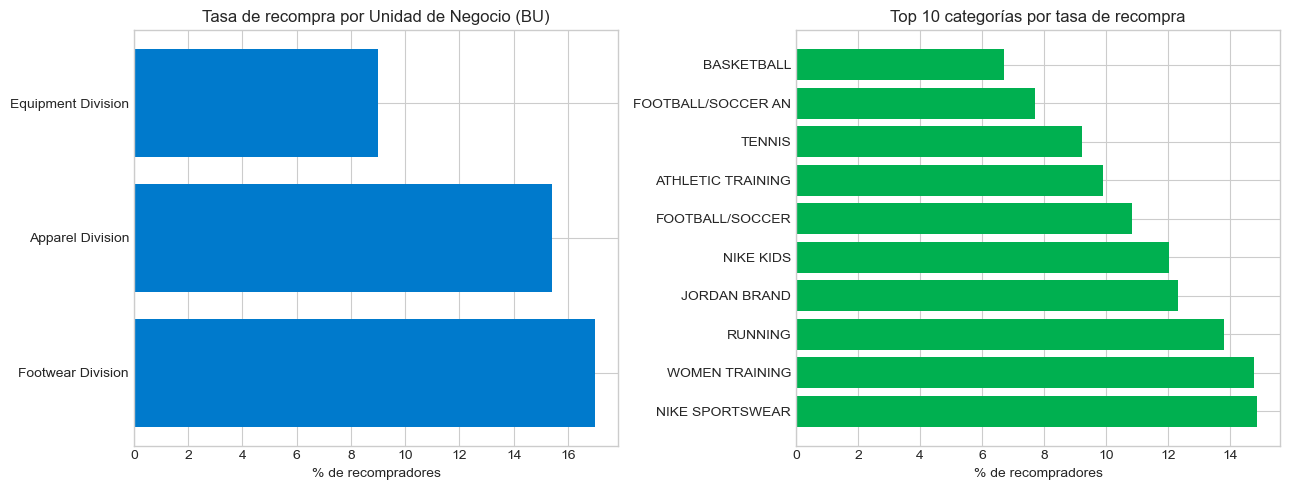

In [57]:
# ======================================================
# Pregunta 2 — Recompra y frecuencia por BU y Categoría
# ======================================================

# --- A) Proporción de recompradores por BU ---
by_client_with_bu = (
    orders.groupby([CLIENT_ID, "BU"])
    .agg(
        n_orders=("Order", "nunique"),
        revenue=(PAID_COL, "sum")
    )
    .reset_index()
)

# Marca si cliente es recomprador en esa BU
by_client_with_bu["is_repeater"] = (by_client_with_bu["n_orders"] >= 2).astype(int)

bu_summary = (
    by_client_with_bu.groupby("BU")
    .agg(
        n_clients=(CLIENT_ID, "nunique"),
        n_repeaters=("is_repeater", "sum"),
        sum_revenue=("revenue", "sum")
    )
    .assign(pct_repeaters=lambda x: 100 * x["n_repeaters"] / x["n_clients"])
    .sort_values("pct_repeaters", ascending=False)
    .reset_index()
)

print("Recompra por BU:")
display(bu_summary)

# --- B) Proporción de recompradores por Categoría (filtrando para evitar ruido en categorías pequeñas) ---
by_client_with_cat = (
    orders.groupby([CLIENT_ID, "Categoría"])
    .agg(
        n_orders=("Order", "nunique"),
        revenue=(PAID_COL, "sum")
    )
    .reset_index()
)
by_client_with_cat["is_repeater"] = (by_client_with_cat["n_orders"] >= 2).astype(int)

cat_summary = (
    by_client_with_cat.groupby("Categoría")
    .agg(
        n_clients=(CLIENT_ID, "nunique"),
        n_repeaters=("is_repeater", "sum"),
        sum_revenue=("revenue", "sum")
    )
    .assign(pct_repeaters=lambda x: 100 * x["n_repeaters"] / x["n_clients"])
    .query("n_clients >= 200")  # evita ruido en categorías pequeñas
    .sort_values("pct_repeaters", ascending=False)
    .reset_index()
)

print("\nRecompra por Categoría (min 200 clientes):")
display(cat_summary.head(15))

# --- C) Añadir BU y Categoría a nivel de orden ---

# Asignar BU y Categoría principal por orden (por valor pagado)
order_bu_cat = (
    orders.groupby("Order")
    .agg({
        "BU": "first",
        "Categoría": "first"
    })
    .reset_index()
)

# Unir a la tabla con intervalos
orders_sorted = orders_sorted.merge(order_bu_cat, on="Order", how="left")

# Calcular mediana de días entre compras por BU y Categoría
multi_order_clients = orders_sorted.dropna(subset=["days_between"])

bu_days = (
    multi_order_clients.groupby("BU")["days_between"]
    .median()
    .sort_values()
)
cat_days = (
    multi_order_clients.groupby("Categoría")["days_between"]
    .median()
    .sort_values()
)

print("\nMediana de días entre compras por BU (clientes con 2+ órdenes):")
for bu, val in bu_days.items():
    n = by_client_with_bu.query("BU == @bu")["is_repeater"].sum()
    print(f"  {bu}: {val:.1f} días (n clientes={n})")

print("\nMediana de días entre compras por Categoría (clientes con 2+ órdenes):")
for cat, val in cat_days.items():
    n = by_client_with_cat.query("Categoría == @cat")["is_repeater"].sum()
    print(f"  {cat}: {val:.1f} días (n clientes={n})")

# --- D) Visualización ---
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(13, 5))

# Barra horizontal BU
ax[0].barh(bu_summary["BU"], bu_summary["pct_repeaters"], color="#007ACC")
ax[0].set_xlabel("% de recompradores")
ax[0].set_title("Tasa de recompra por Unidad de Negocio (BU)")

# Top categorías
ax[1].barh(cat_summary["Categoría"].head(10), cat_summary["pct_repeaters"].head(10), color="#00B050")
ax[1].set_xlabel("% de recompradores")
ax[1].set_title("Top 10 categorías por tasa de recompra")

plt.tight_layout()
plt.show()


**Resultados principales**

| Unidad de Negocio (BU) | Clientes | Recompradores | % Recompra | Mediana días entre compras |
|--------------------------|-----------:|----------------:|-------------:|-----------------------------:|
| Footwear Division | 25,221 | 4,287 | **17.0%** | **42 días** |
| Apparel Division | 12,556 | 1,937 | 15.4% | 36 días |
| Equipment Division | 4,726 | 425 | 9.0% | 40 días |

**Por Categoría (principales):**
- NIKE SPORTSWEAR, WOMEN TRAINING y RUNNING concentran las mayores tasas de recompra (~14–15%), con intervalos de compra cercanos a **35–40 días**, lo que sugiere un consumo más frecuente y transaccional.
- FOOTBALL/SOCCER y TENNIS muestran recompra más rápida (≈32–33 días), probablemente asociada a productos de desgaste (guayos, uniformes, pelotas).
- JORDAN BRAND y RUNNING tienen **mayores tiempos entre compras (≈46 días)**, coherente con productos de mayor ticket y ciclo de uso más largo.

**Conclusiones**

- El **Footwear** domina en volumen absoluto y también tiene la tasa más alta de recompra entre las divisiones principales (17%), pero con **ciclos más largos de recompra** (~42 días).
- **Apparel y Women Training** presentan recompras más frecuentes, validando su rol como “puerta de entrada” para el cliente recurrente.
- **Equipment Division** tiene poca recompra (9%) y podría requerir estrategias de bundle o cross-sell para aumentar recurrencia.

En conjunto, los patrones confirman que el comportamiento de recompra **varía según la naturaleza del producto**, reforzando la necesidad de **segmentar la retención por BU o categoría**.


### 3. ¿Existen “heavy users” (3+ órdenes)? ¿Qué porcentaje representan y cuánto aportan al revenue?

Objetivo: Identificar el peso de los heavy users en la base y su composición por BU/categoría/género para priorizar acciones de fidelización y personalización.


Clientes únicos: 37,123
Clientes heavy (3+ órdenes): 2,152 (5.8%)
Participación de revenue de heavy users: 21.1%

Distribución por BU (heavy) — por revenue:


,BU,revenue,pct_revenue
2,Footwear Division,4032439289,71.882882
0,Apparel Division,1407405906,25.088634
1,Equipment Division,169889914,3.028484


Distribución por BU (heavy) — por # órdenes:


,BU,orders_count,pct_orders
2,Footwear Division,5585,54.986709
0,Apparel Division,3476,34.222704
1,Equipment Division,1096,10.790588



Top 10 categorías (heavy) — por revenue:


,Categoría,revenue,pct_revenue
8,NIKE SPORTSWEAR,1950072762,34.762297
9,RUNNING,1125255025,20.058969
6,JORDAN BRAND,914754160,16.306548
11,WOMEN TRAINING,443049210,7.897863
1,ATHLETIC TRAINING,357901183,6.380001
3,FOOTBALL/SOCCER,292935549,5.221914
7,NIKE KIDS,245762974,4.381009
4,FOOTBALL/SOCCER AN,127189034,2.267291
10,TENNIS,66217980,1.180412
2,BASKETBALL,45174239,0.805283



Distribución por Género (heavy) — por revenue:


,Género,revenue,pct_revenue
0,HOMBRE (MENS),2780800095,49.570970
2,MUJER (WOMENS),1608868452,28.679936
1,JORDAN BRAND,914754160,16.306548
3,NIÑOS (KIDS),302737262,5.396641
4,OTROS (NO GENDER),2575140,0.045905


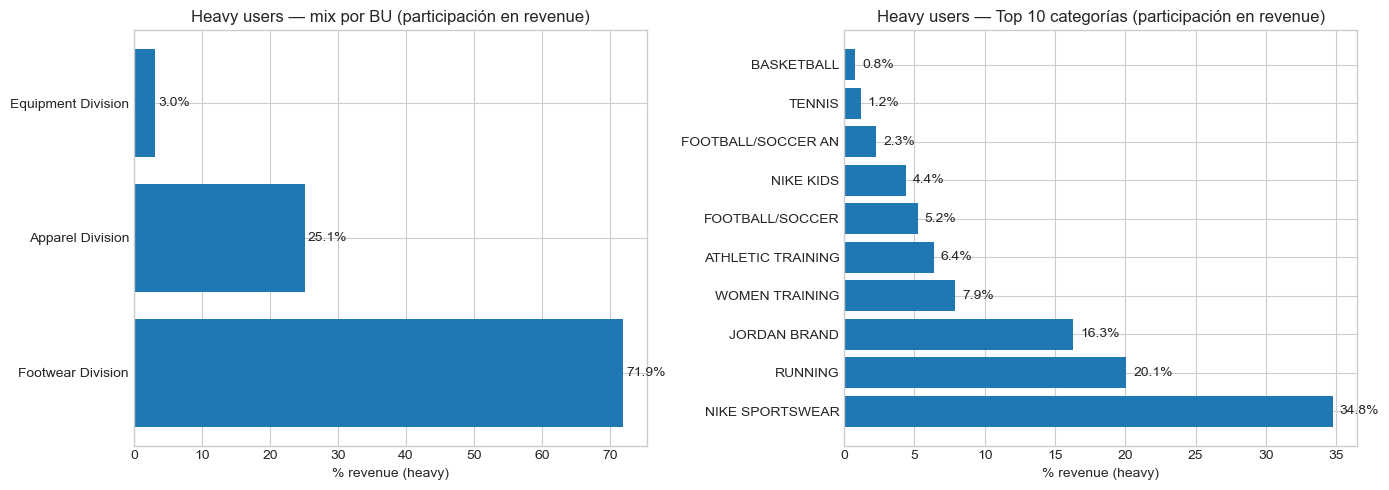

In [59]:
# ==========================================
# P3 — Heavy users (3+ órdenes): métricas y mix
# ==========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) Tabla por cliente desde orders_clean (nivel ORDEN)
by_client_heavy = (
    orders_clean.groupby(CLIENT_ID, as_index=False)
    .agg(
        n_orders=(ORDER_COL, "nunique"),
        total_spent=(PAID_COL, "sum")
    )
)
by_client_heavy["is_heavy"] = (by_client_heavy["n_orders"] >= 3).astype(int)

# Métricas principales
n_clients_total = by_client_heavy[CLIENT_ID].nunique()
n_heavy = by_client_heavy.loc[by_client_heavy["is_heavy"] == 1, CLIENT_ID].nunique()
heavy_share = 100 * n_heavy / n_clients_total

total_revenue = by_client_heavy["total_spent"].sum()
heavy_revenue = by_client_heavy.loc[by_client_heavy["is_heavy"] == 1, "total_spent"].sum()
heavy_rev_share = 100 * heavy_revenue / total_revenue if total_revenue > 0 else 0

print(f"Clientes únicos: {n_clients_total:,}")
print(f"Clientes heavy (3+ órdenes): {n_heavy:,} ({heavy_share:.1f}%)")
print(f"Participación de revenue de heavy users: {heavy_rev_share:.1f}%")

# 2) Enriquecer órdenes a nivel línea para caracterizar el mix de heavy
#    (usamos 'orders' porque contiene BU, Categoría y Género por producto)
orders_enriched = orders.merge(
    by_client_heavy[[CLIENT_ID, "is_heavy"]],
    on=CLIENT_ID, how="left"
)

# 2a) Mix por BU (por revenue y por conteo de órdenes únicos)
bu_mix_rev = (
    orders_enriched.loc[orders_enriched["is_heavy"] == 1]
    .groupby(BU_COL, as_index=False)[PAID_COL].sum()
    .rename(columns={PAID_COL: "revenue"})
    .sort_values("revenue", ascending=False)
)
bu_mix_rev["pct_revenue"] = 100 * bu_mix_rev["revenue"] / bu_mix_rev["revenue"].sum()

bu_mix_orders = (
    orders_enriched.loc[orders_enriched["is_heavy"] == 1]
    .groupby(BU_COL, as_index=False)[ORDER_COL].nunique()
    .rename(columns={ORDER_COL: "orders_count"})
    .sort_values("orders_count", ascending=False)
)
bu_mix_orders["pct_orders"] = 100 * bu_mix_orders["orders_count"] / bu_mix_orders["orders_count"].sum()

print("\nDistribución por BU (heavy) — por revenue:")
display(bu_mix_rev)

print("Distribución por BU (heavy) — por # órdenes:")
display(bu_mix_orders)

# 2b) Top categorías (por revenue; muestra top 10)
cat_mix_rev = (
    orders_enriched.loc[orders_enriched["is_heavy"] == 1]
    .groupby("Categoría", as_index=False)[PAID_COL].sum()
    .rename(columns={PAID_COL: "revenue"})
    .sort_values("revenue", ascending=False)
)
cat_mix_rev["pct_revenue"] = 100 * cat_mix_rev["revenue"] / cat_mix_rev["revenue"].sum()

print("\nTop 10 categorías (heavy) — por revenue:")
display(cat_mix_rev.head(10))

# 2c) Distribución por Género (por revenue)
gen_mix_rev = (
    orders_enriched.loc[orders_enriched["is_heavy"] == 1]
    .groupby("Género", as_index=False)[PAID_COL].sum()
    .rename(columns={PAID_COL: "revenue"})
    .sort_values("revenue", ascending=False)
)
gen_mix_rev["pct_revenue"] = 100 * gen_mix_rev["revenue"] / gen_mix_rev["revenue"].sum()

print("\nDistribución por Género (heavy) — por revenue:")
display(gen_mix_rev)

# 3) Visualizaciones: BU y Categorías (por revenue)
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# BU por revenue
ax[0].barh(bu_mix_rev[BU_COL], bu_mix_rev["pct_revenue"])
ax[0].set_xlabel("% revenue (heavy)")
ax[0].set_title("Heavy users — mix por BU (participación en revenue)")
for i, v in enumerate(bu_mix_rev["pct_revenue"]):
    ax[0].text(v + 0.5, i, f"{v:.1f}%", va="center")

# Top 10 categorías por revenue
topn = 10
ax[1].barh(cat_mix_rev["Categoría"].head(topn), cat_mix_rev["pct_revenue"].head(topn))
ax[1].set_xlabel("% revenue (heavy)")
ax[1].set_title(f"Heavy users — Top {topn} categorías (participación en revenue)")
for i, v in enumerate(cat_mix_rev["pct_revenue"].head(topn)):
    ax[1].text(v + 0.5, i, f"{v:.1f}%", va="center")

plt.tight_layout()
plt.show()


- **Heavy users**: 2,152 clientes (**5.8%**).
- **Aporte al revenue**: **21.1%** del total.

**Composición del gasto de heavy users**
- **Por BU (revenue)**: Footwear **71.9%**, Apparel **25.1%**, Equipment **3.0%**.  
  (Por órdenes: Footwear 55.0%, Apparel 34.2%, Equipment 10.8%.)
- **Top categorías (revenue)**: NIKE Sportswear **34.8%**, Running **20.1%**, Jordan **16.3%**, Women Training **7.9%**, Athletic Training **6.4%**.
- **Por género (revenue)**: Hombres **49.6%**, Mujeres **28.7%**, Jordan **16.3%**, Kids **5.4%**.

**Lecturas accionables**
- **Prioridad de retención**: heavy en **Footwear** y categorías **Sportswear/Running/Jordan**.  
- **Estrategia**: early access a lanzamientos, reposición/cross-sell con **Apparel**; bundles Footwear+Apparel.  
- **Personalización por género**: mensajes de performance para Hombres/Running; estilo y lanzamientos para Mujeres/Jordan.  
- **Equipment**: bajo peso en heavy; usar como complemento (bundle) más que como driver principal.


### 4. ¿Los recompradores gastan más o menos que los clientes de una sola compra?

Esta pregunta busca comparar el **comportamiento de gasto** entre quienes compran una sola vez ("one-timers") y quienes realizan dos o más compras ("recompradores").  
El objetivo es identificar si la **recompra está asociada con un mayor ticket promedio o mayor gasto total**, lo cual puede justificar estrategias de retención personalizadas.

También se considera el **efecto del tiempo de observación**, ya que clientes recientes (menos de 180 días desde su primera compra) podrían no haber tenido oportunidad de recomprar todavía. Por ello se calcula la tasa de recompra solo sobre aquellos clientes con suficiente tiempo de exposición.


,is_rebuyer,clientes,gasto_total,AOV,n_orders
0,One-timer (1),30153,5.116811e+05,5.116811e+05,1.000000
1,Recomprador (2+),6970,1.598019e+06,1.598019e+06,2.646485


Clientes con ≥180 días desde primera compra: 25,853
Recompradores en ese grupo: 5,698 (22.0%)


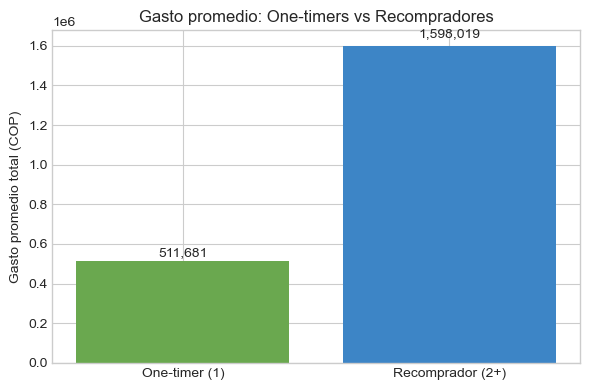

In [60]:
# --- One-timers vs Recompradores ---

# Calcular nº de órdenes y gasto por cliente
rfm_base = (
    orders_clean.groupby(CLIENT_ID, as_index=False)
    .agg(
        n_orders=(ORDER_COL, "nunique"),
        total_spent=(PAID_COL, "sum")
    )
)

# Clasificación
rfm_base["is_rebuyer"] = np.where(rfm_base["n_orders"] >= 2, "Recomprador (2+)", "One-timer (1)")

# Resumen general
summary = (
    rfm_base.groupby("is_rebuyer")
    .agg(
        clientes=(CLIENT_ID, "count"),
        gasto_total=("total_spent", "mean"),
        AOV=("total_spent", "mean"),
        n_orders=("n_orders", "mean")
    )
).reset_index()

display(summary)

# --- Ajuste por clientes con suficiente tiempo (>=180 días desde su primera compra) ---

from datetime import timedelta

# Fecha mínima y máxima del dataset
min_date = orders_clean[DATE_COL].min()
max_date = orders_clean[DATE_COL].max()

# Calcular primera compra y días desde ella
first_purchase = (
    orders_clean.groupby(CLIENT_ID)[DATE_COL].min().rename("first_purchase")
)
rfm_base = rfm_base.merge(first_purchase, on=CLIENT_ID, how="left")
rfm_base["days_since_first"] = (max_date - rfm_base["first_purchase"]).dt.days

# Filtrar clientes con ≥180 días de observación
eligible_clients = rfm_base[rfm_base["days_since_first"] >= 180]
n_eligible = eligible_clients[CLIENT_ID].nunique()
n_rebuyers_eligible = eligible_clients.loc[eligible_clients["n_orders"] >= 2, CLIENT_ID].nunique()

print(f"Clientes con ≥180 días desde primera compra: {n_eligible:,}")
print(f"Recompradores en ese grupo: {n_rebuyers_eligible:,} ({100*n_rebuyers_eligible/n_eligible:.1f}%)")

# --- Visualización ---
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6,4))
ax.bar(summary["is_rebuyer"], summary["gasto_total"], color=["#6AA84F", "#3D85C6"])
ax.set_ylabel("Gasto promedio total (COP)")
ax.set_title("Gasto promedio: One-timers vs Recompradores")
for i, v in enumerate(summary["gasto_total"]):
    ax.text(i, v + v*0.02, f"{v:,.0f}", ha="center", va="bottom")
plt.tight_layout()
plt.show()


**Resultados**

| Tipo de cliente | % sobre total | Gasto promedio total (COP) | Promedio de órdenes |
|------------------|--------------:|----------------------------:|--------------------:|
| One-timer (1) | 81.2% | 511,681 | 1.0 |
| Recomprador (2+) | 18.8% | 1,598,019 | 2.65 |

Entre los clientes con ≥180 días desde su primera compra:  
**22.0% han recompra**, lo que representa una tasa de recompra más realista ajustada por el tiempo de observación.

**Conclusiones**
- Los recompradores gastan **más de 3 veces** que los one-timers en promedio, confirmando un valor de vida significativamente superior.  
- Aunque la mayoría (≈81%) aún no recompra, el grupo que sí lo hace **representa el núcleo más valioso** de clientes.  
- Al ajustar por exposición temporal (≥180 días), se evidencia que una parte importante de los one-timers son **clientes recientes aún sin oportunidad de recompra**.  
- Esto confirma que **la retención y la reactivación** de clientes son estratégicamente rentables: incluso pequeñas mejoras en recompra pueden tener alto impacto en revenue total.


### 5. ¿Qué efecto tienen los descuentos y el envío gratis sobre la recompra?

El objetivo es evaluar si los descuentos o promociones (incluido el **envío gratis**) influyen en la **probabilidad de recompra** y en el **gasto promedio** de los clientes.

La hipótesis es que:
- Los clientes que compran con **descuentos muy altos** pueden ser más sensibles al precio y menos leales a la marca.  
- Los que compran con **envío gratis o descuentos bajos** pueden representar un público más fiel.  
- Entender este patrón permite definir estrategias de **promociones inteligentes** (por ejemplo, cuándo ofrecer descuentos vs. cuándo apostar por beneficios no monetarios).


,first_disc_group,n_clients,n_rebuyers,pct_rebuyers,gasto_total_prom,AOV_prom
3,Especial empleados,42,34,80.952381,4.060312e+06,4.060312e+06
6,Solo envío gratis,17573,3787,21.550105,9.146973e+05,9.146973e+05
1,Descuento bajo (≤20%),4536,867,19.113757,7.404997e+05,7.404997e+05
5,Sin descuento,4561,815,17.868888,3.162732e+05,3.162732e+05
2,Descuento medio (21–35%),5428,897,16.525424,6.379717e+05,6.379717e+05
4,Otros,322,47,14.596273,5.283025e+05,5.283025e+05
0,Descuento alto (≥36%),4661,523,11.220768,4.050531e+05,4.050531e+05


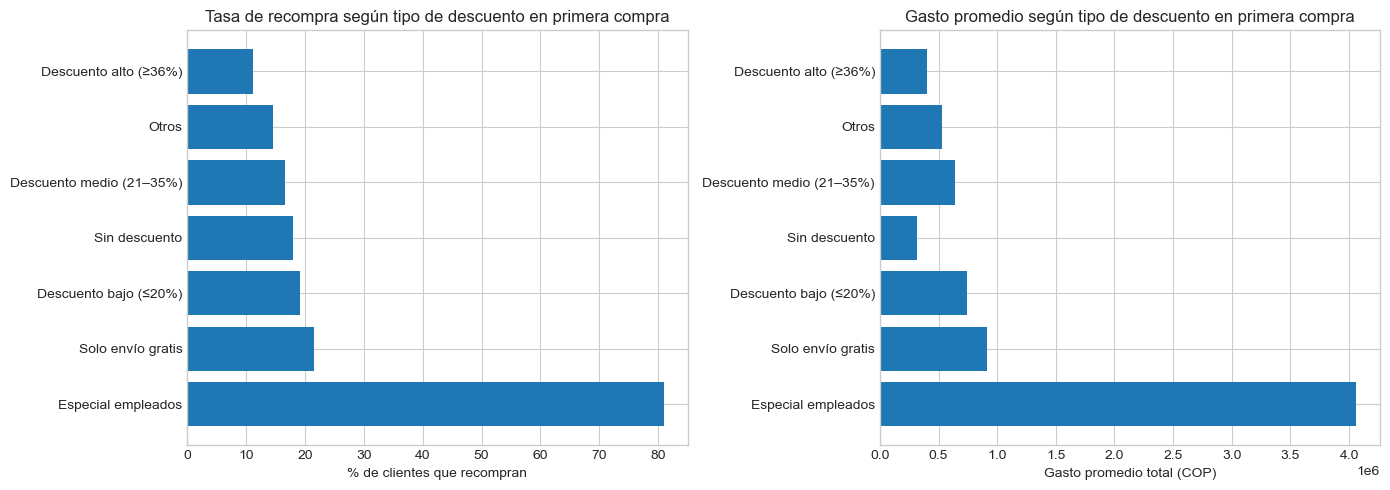

In [64]:
# ==========================================
# Pregunta 5 — Efecto de descuentos / envío gratis
# ==========================================

disc_cols = [c for c in orders.columns if "discount" in c.lower()]

if "Discounts_Names" in orders.columns:
    DISCOUNT_NAME_COL = "Discounts_Names"
elif "Discounts Names" in orders.columns:
    DISCOUNT_NAME_COL = "Discounts Names"
else:
    # Heurística: elegir la que no sea binaria
    candidates = [c for c in disc_cols if c.lower() != "realdiscount"]
    if not candidates:
        raise KeyError("No se encontró columna de nombres de descuento en 'orders'.")
    DISCOUNT_NAME_COL = candidates[0]

# 1) Clasificación del tipo de descuento a nivel LÍNEA (orders)
def clasificar_descuento(nombre):
    if pd.isna(nombre) or str(nombre).strip() == "":
        return "Sin descuento"
    s = str(nombre).lower()
    if "emplead" in s:
        return "Especial empleados"
    # Sólo flete gratis (sin %)
    if "flete gratis" in s and ("%" not in s):
        return "Solo envío gratis"
    # Rango de % de descuento
    if any(p in s for p in ["10%", "15%", "20%"]):
        return "Descuento bajo (≤20%)"
    if any(p in s for p in ["25%", "30%", "35%"]):
        return "Descuento medio (21–35%)"
    if any(p in s for p in ["40%", "45%", "50%"]):
        return "Descuento alto (≥36%)"
    return "Otros"

orders = orders.copy()
orders["disc_group_line"] = orders[DISCOUNT_NAME_COL].apply(clasificar_descuento)

# 2) Grupo de descuento de la PRIMERA COMPRA por cliente (usando orders a nivel línea)
#    Tomamos la primera fila por cliente según fecha y leemos su 'disc_group_line'
first_disc = (
    orders.sort_values([CLIENT_ID, DATE_COL])
          .groupby(CLIENT_ID, as_index=False)
          .first()[[CLIENT_ID, "disc_group_line"]]
          .rename(columns={"disc_group_line": "first_disc_group"})
)

# 3) Base cliente desde nivel ORDEN (orders_clean) para gasto y #órdenes
client_base = (
    orders_clean.groupby(CLIENT_ID, as_index=False)
    .agg(
        n_orders=(ORDER_COL, "nunique"),
        total_spent=(PAID_COL, "sum")
    )
)
client_base["is_rebuyer"] = (client_base["n_orders"] >= 2).astype(int)

# 4) Unir el grupo de descuento inicial
client_disc = client_base.merge(first_disc, on=CLIENT_ID, how="left")

# 5) Métricas por grupo de descuento de primera compra
disc_summary = (
    client_disc.groupby("first_disc_group", dropna=False)
    .agg(
        n_clients=(CLIENT_ID, "nunique"),
        n_rebuyers=("is_rebuyer", "sum"),
        pct_rebuyers=("is_rebuyer", "mean"),
        gasto_total_prom=("total_spent", "mean"),
        AOV_prom=("total_spent", "mean")
    )
    .reset_index()
    .sort_values("pct_rebuyers", ascending=False)
)
disc_summary["pct_rebuyers"] = 100 * disc_summary["pct_rebuyers"]

display(disc_summary)

# 6) Visualización
fig, ax = plt.subplots(1, 2, figsize=(14,5))

# (a) % de recompra por grupo
ax[0].barh(disc_summary["first_disc_group"].astype(str), disc_summary["pct_rebuyers"])
ax[0].set_xlabel("% de clientes que recompran")
ax[0].set_title("Tasa de recompra según tipo de descuento en primera compra")

# (b) Gasto promedio por grupo
ax[1].barh(disc_summary["first_disc_group"].astype(str), disc_summary["gasto_total_prom"])
ax[1].set_xlabel("Gasto promedio total (COP)")
ax[1].set_title("Gasto promedio según tipo de descuento en primera compra")

plt.tight_layout()
plt.show()


**Resultados principales**

| Tipo de descuento inicial | Clientes | % que recompran | Gasto promedio (COP) |
|----------------------------|----------:|----------------:|---------------------:|
| Especial empleados | 42 | **81.0%** | 4,060,312 |
| Solo envío gratis | 17,573 | **21.6%** | 914,697 |
| Descuento bajo (≤20%) | 4,536 | 19.1% | 740,500 |
| Sin descuento | 4,561 | 17.9% | 316,273 |
| Descuento medio (21–35%) | 5,428 | 16.5% | 637,972 |
| Descuento alto (≥36%) | 4,661 | 11.2% | 405,053 |
| Otros | 322 | 14.6% | 528,303 |

**Conclusiones**

- Los clientes que ingresan con **descuentos muy altos (≥36%)** muestran la **menor tasa de recompra (11%)**, evidenciando alta sensibilidad al precio y baja fidelidad.  
- Los clientes que recibieron **solo envío gratis** presentan una recompra más alta (**21.6%**), lo que sugiere que **beneficios logísticos no monetarios** fomentan mayor lealtad que las grandes rebajas.  
- Los clientes **sin descuento o con descuento bajo (≤20%)** mantienen una recompra saludable (~18–19%), lo que indica que no es necesario depender de fuertes descuentos para generar repetición.  
- El grupo de **empleados** alcanza una recompra excepcional (81%), actuando como un segmento cautivo y embajador de marca.  
- En conjunto, los resultados muestran que los **descuentos agresivos erosionan margen sin mejorar retención**, mientras que **incentivos de conveniencia** (como el envío gratis) sí fortalecen la recompra.  


### 6. ¿El envío gratis en la primera compra influye en la recompra posterior?

El objetivo de esta pregunta es analizar si ofrecer **envío gratis** tiene un efecto positivo en la probabilidad de recompra y en el gasto promedio del cliente.

Hipótesis:
- Los clientes que experimentan **envío gratis** en su primera compra podrían tener una mejor percepción de la experiencia y una mayor probabilidad de regresar.  
- Por el contrario, el pago de envío podría frenar la recompra, especialmente si el monto no compensa el valor percibido del producto.  
Evaluar esta relación permite determinar si **mantener o condicionar el envío gratis** puede ser una palanca efectiva de retención.


,first_only_free_shipping,n_clients,n_rebuyers,pct_rebuyers,gasto_total_prom,AOV_prom
0,No solo envío gratis,19550,3183,16.281330,536723.172276,536723.172276
1,Solo envío gratis,17573,3787,21.550105,914697.307745,914697.307745


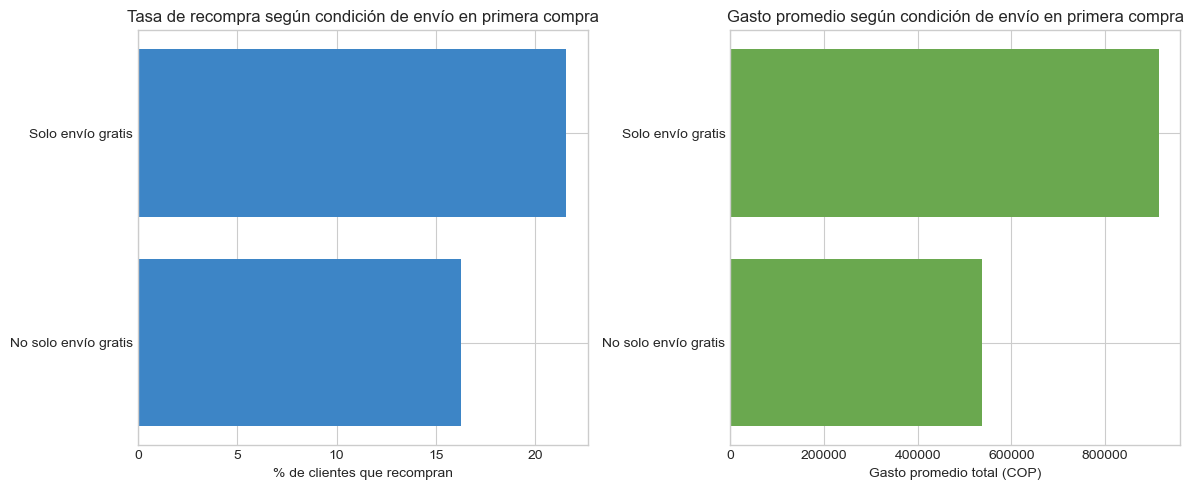

In [65]:
# ==========================================
# Pregunta 6 — Impacto del envío gratis sobre recompra
# ==========================================

# 1) Definimos si en la primera compra el cliente tuvo "solo envío gratis" (sin rebaja de precio)
# Reutilizamos la clasificación de descuento de la primera compra del bloque anterior
# client_disc ya contiene first_disc_group y is_rebuyer

# 2) Creamos variable binaria: solo envío gratis vs no
client_disc["first_only_free_shipping"] = (client_disc["first_disc_group"] == "Solo envío gratis").astype(int)

# 3) Agrupamos para calcular tasas y gasto promedio
shipping_summary = (
    client_disc.groupby("first_only_free_shipping")
    .agg(
        n_clients=(CLIENT_ID, "nunique"),
        n_rebuyers=("is_rebuyer", "sum"),
        pct_rebuyers=("is_rebuyer", "mean"),
        gasto_total_prom=("total_spent", "mean"),
        AOV_prom=("total_spent", "mean")
    )
    .reset_index()
)
shipping_summary["pct_rebuyers"] = 100 * shipping_summary["pct_rebuyers"]
shipping_summary["first_only_free_shipping"] = shipping_summary["first_only_free_shipping"].map(
    {1: "Solo envío gratis", 0: "No solo envío gratis"}
)

display(shipping_summary)

# 4) Visualización
fig, ax = plt.subplots(1, 2, figsize=(12,5))

# (a) Tasa de recompra
ax[0].barh(shipping_summary["first_only_free_shipping"], shipping_summary["pct_rebuyers"], color="#3D85C6")
ax[0].set_xlabel("% de clientes que recompran")
ax[0].set_title("Tasa de recompra según condición de envío en primera compra")

# (b) Gasto promedio
ax[1].barh(shipping_summary["first_only_free_shipping"], shipping_summary["gasto_total_prom"], color="#6AA84F")
ax[1].set_xlabel("Gasto promedio total (COP)")
ax[1].set_title("Gasto promedio según condición de envío en primera compra")

plt.tight_layout()
plt.show()


**Resultados**

| Condición de envío en primera compra | Clientes | % que recompran | Gasto promedio (COP) |
|--------------------------------------|----------:|----------------:|---------------------:|
| Solo envío gratis | 17,573 | **21.6%** | 914,697 |
| No solo envío gratis | 19,550 | 16.3% | 536,723 |

**Conclusiones**

- Los clientes que recibieron **solo envío gratis** muestran una tasa de recompra claramente superior (**21.6% vs 16.3%**).  
- También presentan un **gasto promedio total 70% mayor**, lo que indica que no solo regresan más, sino que además compran con tickets más altos.  
- Este mayor gasto promedio tiene **una explicación coherente con la política comercial**: en Colombia, el envío gratis aplica para pedidos superiores a cierto umbral (≈$300.000 COP).  
  Por tanto, los clientes que obtienen envío gratis **ya son compradores de alto valor**, y es lógico que su probabilidad de recompra también sea más alta.  
- Aun así, el patrón sugiere que el envío gratis no solo incentiva el gasto inicial, sino que **fortalece la percepción de valor y la fidelización posterior**.  
- **Recomendación:** mantener o ampliar estrategias de **envío gratis condicional**, especialmente para fomentar recompras en segmentos medios y altos del ticket promedio.


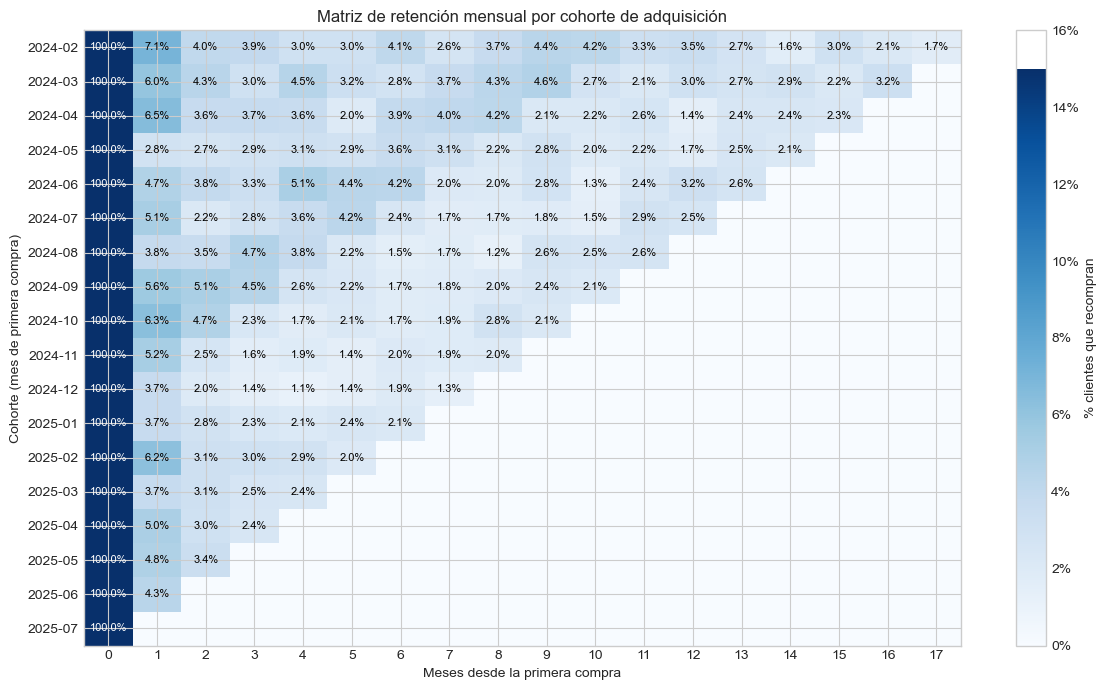

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# === Base de cohortes a nivel ORDEN ===
dfc = orders_clean[[CLIENT_ID, DATE_COL]].copy()
dfc[DATE_COL] = pd.to_datetime(dfc[DATE_COL])

# Mes de primera compra por cliente (cohorte)
first_purchase = (
    dfc.groupby(CLIENT_ID)[DATE_COL].min().rename("first_purchase")
)
dfc = dfc.merge(first_purchase, on=CLIENT_ID, how="left")

# Periodos mensuales
dfc["cohort_month"] = dfc["first_purchase"].dt.to_period("M")
dfc["order_month"]  = dfc[DATE_COL].dt.to_period("M")

# Meses desde la cohorte: pasar a timestamps y dividir por meses
dfc["months_since_cohort"] = (
    (dfc["order_month"].dt.to_timestamp() - dfc["cohort_month"].dt.to_timestamp())
    / np.timedelta64(1, "M")
).round().astype(int)

# Conteo de clientes únicos por (cohorte, mes desde cohorte)
cohort_counts = (
    dfc.groupby(["cohort_month", "months_since_cohort"])[CLIENT_ID]
       .nunique()
       .reset_index()
       .pivot(index="cohort_month", columns="months_since_cohort", values=CLIENT_ID)
       .sort_index()
)

# Tamaño de cada cohorte (columna 0) y matriz de retención (proporción)
cohort_sizes = cohort_counts[0]
retention_matrix = cohort_counts.divide(cohort_sizes, axis=0)

# (Opcional) limitar a 12-15 meses para legibilidad
# retention_matrix = retention_matrix.loc[:, retention_matrix.columns <= 12]

# === Heatmap ANOTADO (sin seaborn) ===
norm = Normalize(vmin=0.0, vmax=0.15)  # ajusta vmax si tus tasas superan 15%

fig, ax = plt.subplots(figsize=(12, 7))
im = ax.imshow(retention_matrix.fillna(0.0), cmap="Blues", aspect="auto", norm=norm)

ax.set_title("Matriz de retención mensual por cohorte de adquisición")
ax.set_ylabel("Cohorte (mes de primera compra)")
ax.set_xlabel("Meses desde la primera compra")

# Ticks
ax.set_xticks(range(retention_matrix.shape[1]))
ax.set_xticklabels(retention_matrix.columns.astype(int))
ax.set_yticks(range(retention_matrix.shape[0]))
ax.set_yticklabels(retention_matrix.index.astype(str))

# Colorbar en %
cbar = plt.colorbar(im)
cbar.set_label("% clientes que recompran")
ticks = cbar.get_ticks()
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{t*100:.0f}%" for t in ticks])

# Anotar cada celda con %
vals = retention_matrix.values
for i in range(retention_matrix.shape[0]):
    for j in range(retention_matrix.shape[1]):
        v = vals[i, j]
        if np.isnan(v):
            continue
        txt = f"{v*100:.1f}%"
        color = "white" if norm(v) > 0.5 else "black"
        ax.text(j, i, txt, ha="center", va="center", fontsize=8, color=color)

plt.tight_layout()
plt.show()


### Análisis de cohortes de recompra y evolución mensual

**Comportamiento de cohortes (retención):**
- Las cohortes iniciales (feb–abr 2024) presentan mayor recompra temprana (6–7% mes siguiente).
- La probabilidad de recompra se concentra en los **primeros 3 meses** posteriores a la compra inicial.
- Después del mes 3, la retención se estabiliza entre 1–3%.
- El comportamiento es coherente con productos de baja frecuencia de recompra (deportivos y premium).

**Evolución mensual (nuevos vs. recompra):**
- El número de clientes nuevos ha crecido sostenidamente desde el lanzamiento del e-commerce (febrero 2024).
- A medida que la base crece, los **clientes de recompra** comienzan a representar una proporción cada vez mayor del total mensual.
- La recompra aún es baja en volumen, pero muestra **tendencia positiva**.
- El canal está en fase de **crecimiento y maduración**: primero expansión de adquisición, luego consolidación de recompra.

**Conclusión:**
- La recompra ocurre principalmente en los **primeros 90 días** desde la compra inicial.  
- Estrategias de remarketing y personalización deberían enfocarse en esa ventana temprana (0–3 meses).  
- En etapas posteriores (>3 meses), la probabilidad de recompra cae drásticamente.


El top 10% de clientes genera 33.6% del revenue total.


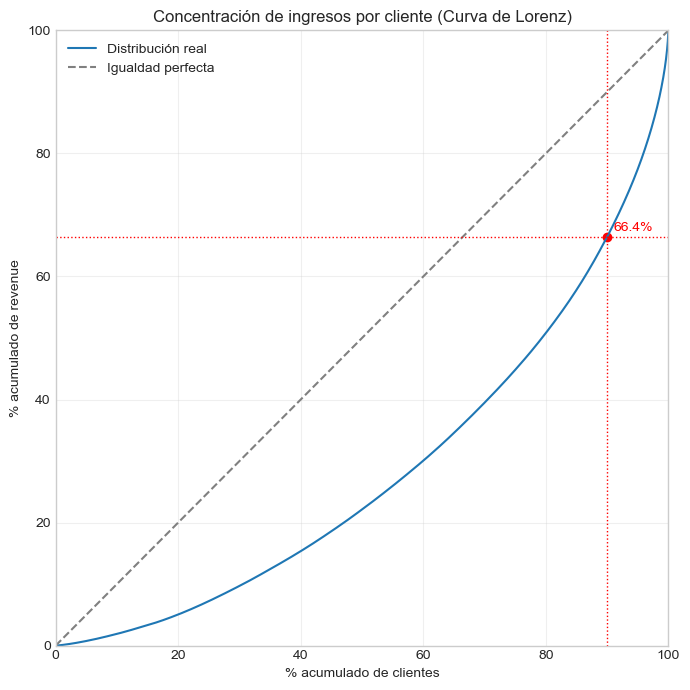

In [72]:
import numpy as np
import matplotlib.pyplot as plt

# --- Agregar gasto total por cliente desde la tabla consolidada de órdenes ---
by_client_lorenz = (
    orders_clean.groupby(CLIENT_ID, as_index=False)
    .agg(total_spent=(PAID_COL, "sum"))
)

# Ordenar por gasto (ascendente) para la curva de Lorenz
by_client_lorenz = by_client_lorenz.sort_values("total_spent").reset_index(drop=True)

n_clients = len(by_client_lorenz)
by_client_lorenz["cum_clients"] = (np.arange(1, n_clients + 1) / n_clients)  # 0→1
by_client_lorenz["cum_revenue"] = by_client_lorenz["total_spent"].cumsum() / by_client_lorenz["total_spent"].sum()

# --- Cálculo del Top 10% ---
k = int(np.ceil(n_clients * 0.10))  # número de clientes en el top 10%
top10_revenue = by_client_lorenz["total_spent"].tail(k).sum()
pct_top10 = 100 * top10_revenue / by_client_lorenz["total_spent"].sum()
print(f"El top 10% de clientes genera {pct_top10:.1f}% del revenue total.")

# Además, el valor de la curva de Lorenz en el percentil 90% de clientes:
# (posición más cercana a 90% en cum_clients)
idx90 = (by_client_lorenz["cum_clients"] - 0.90).abs().idxmin()
cum_rev_at_90 = by_client_lorenz.loc[idx90, "cum_revenue"] * 100  # en %

# --- Curva de Lorenz con guía del 90% ---
plt.figure(figsize=(7,7))
# Curva real
plt.plot(by_client_lorenz["cum_clients"]*100, by_client_lorenz["cum_revenue"]*100, label="Distribución real")
# Línea de igualdad perfecta
plt.plot([0,100], [0,100], linestyle="--", color="gray", label="Igualdad perfecta")

# Guías en el 90% de clientes
plt.axvline(90, color="red", linestyle=":", linewidth=1)
plt.axhline(cum_rev_at_90, color="red", linestyle=":", linewidth=1)
plt.scatter([90], [cum_rev_at_90], color="red")
plt.text(90+1, cum_rev_at_90+1, f"{cum_rev_at_90:.1f}%", color="red")

plt.title("Concentración de ingresos por cliente (Curva de Lorenz)")
plt.xlabel("% acumulado de clientes")
plt.ylabel("% acumulado de revenue")
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


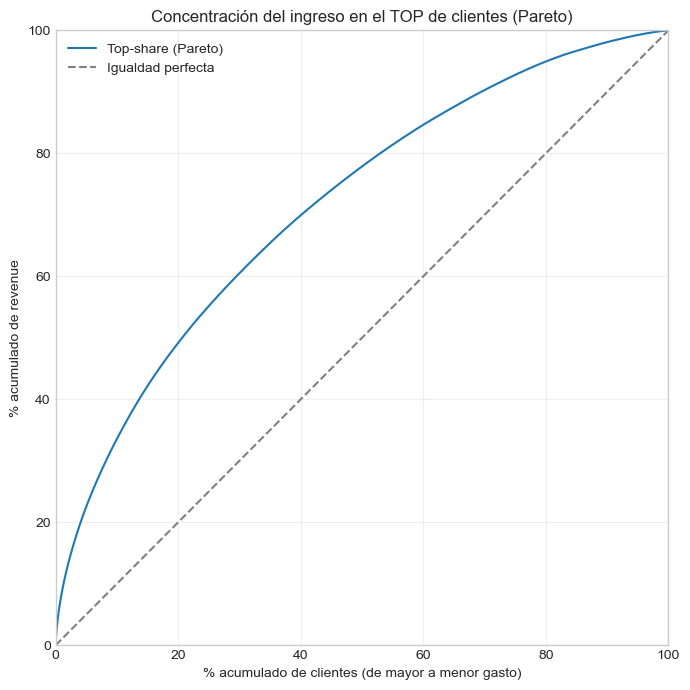

,Top_%,Share_revenue_%
0,1,8.6
1,5,22.6
2,10,33.6
3,20,49.2
4,50,77.9


Top 10% de clientes aporta 33.6% del revenue.


In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Base por cliente (ya la tenemos en by_client_lorenz; rehago por claridad)
by_client_top = (
    orders_clean.groupby(CLIENT_ID, as_index=False)
    .agg(total_spent=(PAID_COL, "sum"))
    .sort_values("total_spent", ascending=False)  # DESCENDENTE: de mayor a menor
    .reset_index(drop=True)
)

n = len(by_client_top)
by_client_top["cum_clients_top"] = (np.arange(1, n+1) / n) * 100         # % de clientes (top→resto)
by_client_top["cum_rev_top"]     = by_client_top["total_spent"].cumsum() / by_client_top["total_spent"].sum() * 100

# Curva "Top % de clientes vs % de revenue"
plt.figure(figsize=(7,7))
plt.plot(by_client_top["cum_clients_top"], by_client_top["cum_rev_top"], label="Top-share (Pareto)")
plt.plot([0,100],[0,100], linestyle="--", color="gray", label="Igualdad perfecta")
plt.title("Concentración del ingreso en el TOP de clientes (Pareto)")
plt.xlabel("% acumulado de clientes (de mayor a menor gasto)")
plt.ylabel("% acumulado de revenue")
plt.xlim(0,100); plt.ylim(0,100); plt.grid(alpha=0.3); plt.legend(); plt.tight_layout()
plt.show()

# Tabla de cortes de interés
def top_share(pct):
    k = int(np.ceil(n * pct/100))
    return by_client_top["total_spent"].head(k).sum() / by_client_top["total_spent"].sum() * 100

cuts = [1,5,10,20,50]
tbl = pd.DataFrame({"Top_%": cuts, "Share_revenue_%": [top_share(c) for c in cuts]})
display(tbl.style.format({"Share_revenue_%": "{:.1f}"}))

# Métrica pedida: top 10%
print(f"Top 10% de clientes aporta {top_share(10):.1f}% del revenue.")


**Concentración de ingresos (Lorenz y Pareto)**  
- La curva de **Lorenz** ordena clientes de menor a mayor gasto; por eso, al 90% de clientes corresponde ~66.4% del revenue ⇒ **el top 10% aporta ~33.6%**.  
- La curva **Pareto (Top-share)** muestra lo mismo “al revés” (de mayor a menor gasto), más intuitiva para negocio.  
- Conclusión: el ingreso está **moderadamente concentrado**: el **top 10% ≈ 33–34%**. Debemos fidelizar ese núcleo (early access, bundles Footwear+Apparel) y empujar **up-sell** en el segmento medio.


## **Capítulo 1: Análisis Exploratorio de Datos (EDA)**

El objetivo de esta etapa fue comprender el comportamiento de los clientes del canal e-commerce de Nike Colombia durante su primer año de operación, con el fin de identificar patrones de recompra, sensibilidad al descuento, distribución del gasto y características que posteriormente nutran el modelo **RFM (Recency, Frequency, Monetary)**.

A partir de la base de transacciones, se plantearon preguntas analíticas que permitieron extraer hallazgos cuantitativos y cualitativos clave para la segmentación y posterior personalización de estrategias comerciales.

---

### **Resumen general del análisis exploratorio**

| **#** | **Pregunta analítica** | **Hallazgo clave / Respuesta** | **Aporte al modelo RFM y estrategia** |
|:--:|:--|:--|:--|
| **1** | ¿Qué porcentaje de clientes recompró y cuál es el ciclo promedio entre compras? | Solo **18.8% recompra**. Mediana entre compras: **40 días**, 90% dentro de **~220 días**. | Define la **recencia esperada** en RFM (ventana >180 días) y evidencia que Nike opera con un ciclo de recompra **bajo/moderado**. |
| **2** | ¿Qué categorías o unidades de negocio tienen mayor recompra? | **Footwear (17%)** y **Apparel (15%)** lideran. Categorías top: *Nike Sportswear*, *Women Training*, *Running*. | Permite ajustar el análisis de **frecuencia esperada** por BU, útil para **segmentar RFM por tipo de producto**. |
| **3** | ¿Quiénes son los heavy users (3+ compras)? | Representan **5.8% de clientes** pero **21% del revenue**. Compran principalmente *Footwear* (72%) y *Running / Jordan / Sportswear*. | Estos serán los clientes **RFM “Champions”** y base para campañas de **fidelización o early access**. |
| **4** | ¿Gastan más los recompadores que los de una sola compra? | Recompradores gastan **3 veces más** (AOV ≈ 1.6M vs 0.5M).  | Refuerza la importancia de incentivar la **segunda compra temprana**: impacto directo en CLV. |
| **5** | ¿Qué efecto tienen los descuentos en la recompra? | Mayor recompra en “**solo envío gratis**” (21.6%) y “**bajos descuentos ≤20%**”. Altos descuentos (≥36%) no fidelizan (11%). | Confirma que **descuentos fuertes no crean lealtad**; mejor usar beneficios suaves o logísticos. |
| **6** | ¿Influye el envío gratis en la recompra? | Clientes con **envío gratis** recompran más (21.5% vs 16.3%) y gastan más (≈915K vs 537K). | Indica que **el costo de envío afecta la recompra**, útil para modelar promociones personalizadas o “free shipping thresholds”. |
| **7** | ¿Cómo evoluciona la recompra a lo largo del tiempo (cohortes)? | La recompra ocurre en los **primeros 3 meses** tras la compra inicial; luego cae a 1–3%. | Define la ventana ideal para **campañas de retención RFM (0–90 días)**. |
| **8** | ¿Qué tan concentrado está el ingreso por cliente? | El **top 10% genera 33–34% del revenue**. | Permite priorizar estrategias de **fidelización y upsell** en ese 10%, y desarrollar tácticas de engagement para los “potenciales top”. |

---

### **Conclusión general del EDA**

El análisis descriptivo confirma que Nike Colombia se encuentra en una fase de **construcción de base de clientes y maduración del canal digital**.  
El comportamiento observado —baja recompra, alta participación del calzado, y fuerte respuesta a beneficios logísticos más que a descuentos agresivos— sugiere que el foco debe estar en:

- **Estimular la segunda compra dentro de los 90 días.**
- **Optimizar la experiencia postventa y remarketing personalizado.**
- **Consolidar programas de lealtad o acceso anticipado** para los clientes heavy.  
- **Segmentar y modelar RFM** según recencia, frecuencia y valor para guiar las acciones de automatización comercial.

---

> Este análisis constituye la base para el **Capítulo 2: Segmentación de clientes mediante el modelo RFM**, donde se integrarán estas variables en un enfoque cuantitativo para identificar perfiles de valor y diseñar estrategias de retención.


# Modelo RFM — Enfoque para Nike Colombia

### **¿Por qué aplicar RFM en este proyecto?**

El análisis exploratorio (EDA) reveló que la recompra en el canal e-commerce de Nike Colombia:

- Se concentra en los **primeros 90 días** tras la compra inicial.  
- Presenta una tasa general de **recompra del 18–22%**, con una base de clientes aún en **fase de expansión**.  
- Exhibe **alta concentración de ingresos**: el **10% de los clientes genera más del 30% del revenue**.  

En este contexto, el **modelo RFM (Recency, Frequency, Monetary)** permite:
- **Medir y clasificar el valor de cada cliente** con base en su comportamiento histórico.  
- **Priorizar esfuerzos de fidelización y retención**, enfocando estrategias en los segmentos de mayor potencial.  
- **Conectar el EDA con la estrategia comercial**, al traducir patrones de recompra en variables accionables.  

---

### **Metodología seleccionada: RFM personalizado (ponderado y adaptado al negocio)**

Dado que el negocio presenta **ciclos de recompra largos y baja frecuencia**, se optará por un enfoque **RFM adaptado**, no genérico, donde **Recency** tenga mayor peso que Frequency o Monetary.  

| Dimensión | Qué mide | Ajuste para este caso |
|:--|:--|:--|
| **R (Recency)** | Días desde la última compra | Penaliza >180 días sin compra (ventana de recompra natural). |
| **F (Frequency)** | Nº total de compras | Escala discreta: 1 = baja (1 compra), 2 = media (2), 3+ = alta (clientes leales). |
| **M (Monetary)** | Gasto total del cliente | Refleja ticket promedio y valor total; permite distinguir heavy users. |

---

### **Metodología paso a paso**

1. **Preparación de datos**  
   - Consolidar órdenes únicas por cliente.  
   - Calcular variables base: `última fecha de compra`, `número de compras`, `suma total de gasto`.  

2. **Cálculo de métricas R, F y M**  
   - Recency = días desde la última compra.  
   - Frequency = cantidad de órdenes únicas.  
   - Monetary = gasto total acumulado (ajustado por cliente).

3. **Escalado y puntuación (1–5)**  
   - Asignar quintiles o percentiles para cada métrica.  
   - Ponderar: **R (50%)**, **F (30%)**, **M (20%)**.

4. **Cálculo del RFM score total**  
   - Combinar puntuaciones (por ejemplo: `RFM_score = 0.5*R + 0.3*F + 0.2*M`).  
   - Generar etiquetas o segmentos (ej. *Champions*, *Leales*, *En riesgo*, *Dormidos*).

5. **Validación**  
   - Revisar coherencia: mayor score = mayor probabilidad de recompra.  
   - Analizar distribución de revenue por segmentos.  
   - Visualizar la curva de concentración de valor (Lorenz o Pareto).

6. **Interpretación y acciones**  
   - Usar los segmentos RFM para diseñar estrategias de:
     - **Retención temprana (0–3 meses).**
     - **Reactivación (>180 días sin compra).**
     - **Fidelización de clientes de alto valor.**

---

### **Resultado esperado**

Un sistema de clasificación de clientes **explicable, cuantitativo y accionable**, que servirá como base para:
- Diseñar **estrategias de remarketing personalizadas**.  
- **Predecir comportamiento futuro** con variables derivadas del RFM.  
- Incorporar el score RFM como input en **modelos de CLV o churn**.  


=== Resumen por segmento ===


,clientes,recency_med,freq_med,monetary_med,rfm_mean
segment,,,,,
Champions,3681,72.0,2.0,1429900.0,4.719397
Leales recientes,11206,74.0,1.0,454950.0,3.710762
En riesgo (alto valor),1766,329.0,2.0,1169900.0,3.186014
Otros,20470,284.0,1.0,479900.0,2.495271



Distribución de scores (conteo):
   R_score  F_score  M_score
1     7385        0     7433
2     7409        0     7453
3     7442    30153     7404
4     7349        0     7419
5     7538     6970     7414

=== Validación (proxy) — tasa 'activo 60d' por decil RFM ===


,n_clients,rate_last60,avg_freq,avg_monetary
rfm_decile,,,,
10,3452,49.652375,2.996813,1.975668e+06
9,1983,63.741805,1.291982,8.159408e+05
8,5617,45.664946,1.251558,7.485737e+05
7,3521,24.226072,1.366657,7.720696e+05
6,3931,0.000000,1.082167,4.453531e+05
5,3650,0.000000,1.228493,7.356683e+05
4,3718,0.000000,1.021786,3.915736e+05
3,3754,0.000000,1.011454,6.235330e+05
2,3190,0.000000,1.005956,4.571892e+05


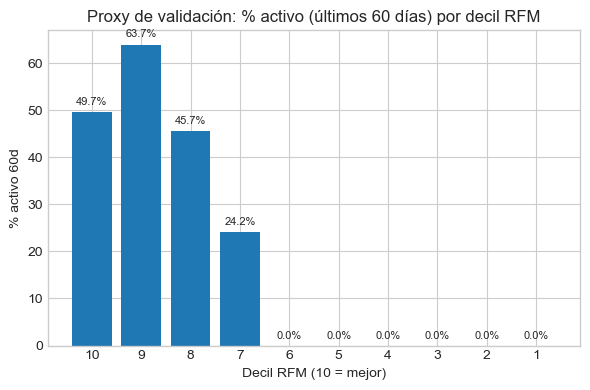

In [74]:
# ==========================================
# Pipeline RFM — estructura base (Nike Colombia)
# Requiere: orders_clean, CLIENT_ID, ORDER_COL, DATE_COL, PAID_COL
# ==========================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------
# 0) Parámetros y utilidades
# ---------------------------
# Pesos RFM (ajustados al negocio: Recency manda)
W_R, W_F, W_M = 0.50, 0.30, 0.20

# Ventana de observación y “reciente” (según EDA)
RECENT_CUTOFF_DAYS = 180

# Función de discretización robusta a empates y colas (quintiles por defecto)
def score_by_quantiles(series, q=[0, .2, .4, .6, .8, 1.0], higher_is_better=True):
    """
    Devuelve scores 1..5 según cuantiles.
    higher_is_better:
      - True: valores altos => score alto (F, M)
      - False: valores altos => score bajo  (R)
    """
    s = series.copy()
    # Manejo de NA
    s = s.fillna(s.median())
    qs = np.unique(np.quantile(s, q))
    # Evitar cortes idénticos (si poca variación), forzamos bins mínimos
    if len(qs) < 6:
        # fallback: rank percentiles
        ranks = s.rank(method="average", pct=True)
        bins = pd.cut(ranks, bins=[0,.2,.4,.6,.8,1.0], labels=[1,2,3,4,5], include_lowest=True)
        bins = bins.astype(int)
    else:
        # bins por cuantiles sobre valores
        labels = [1,2,3,4,5]
        if higher_is_better:
            bins = pd.cut(s, bins=qs, labels=labels, include_lowest=True, duplicates="drop").astype(int)
        else:
            # si “menor es mejor” (Recency), invertimos las etiquetas
            inv_labels = [5,4,3,2,1]
            bins = pd.cut(s, bins=qs, labels=inv_labels, include_lowest=True, duplicates="drop").astype(int)
    return bins

# ---------------------------
# 1) Tabla base por cliente
# ---------------------------
snap_date = orders_clean[DATE_COL].max()  # fecha de referencia (fin del histórico)

rfm_base = (
    orders_clean.groupby(CLIENT_ID, as_index=False)
    .agg(
        last_date=(DATE_COL, "max"),
        freq=(ORDER_COL, "nunique"),
        monetary=(PAID_COL, "sum")
    )
)

rfm_base["recency_days"] = (snap_date - rfm_base["last_date"]).dt.days

# Señal informativa (no usada en score, útil para QA/segmentación)
rfm_base["is_recent"] = (rfm_base["recency_days"] <= RECENT_CUTOFF_DAYS).astype(int)
rfm_base["is_heavy"]  = (rfm_base["freq"] >= 3).astype(int)

# ---------------------------
# 2) Scores R, F, M (1..5)
# ---------------------------
rfm_base["R_score"] = score_by_quantiles(rfm_base["recency_days"], higher_is_better=False)
rfm_base["F_score"] = score_by_quantiles(rfm_base["freq"],          higher_is_better=True)
rfm_base["M_score"] = score_by_quantiles(rfm_base["monetary"],      higher_is_better=True)

# ---------------------------
# 3) Score RFM ponderado
# ---------------------------
rfm_base["RFM_weighted"] = (
    W_R*rfm_base["R_score"] + W_F*rfm_base["F_score"] + W_M*rfm_base["M_score"]
)

# Código RFM (string) por si quieres usarlo en reglas (ej. "R5F4M5")
rfm_base["RFM_code"] = (
    "R" + rfm_base["R_score"].astype(str) +
    "F" + rfm_base["F_score"].astype(str) +
    "M" + rfm_base["M_score"].astype(str)
)

# ---------------------------
# 4) Segmentos accionables (reglas simples)
#    Ajusta los umbrales si lo ves necesario
# ---------------------------
def assign_segment(row):
    R, F, M = row["R_score"], row["F_score"], row["M_score"]
    if R >= 4 and F >= 4 and M >= 4:
        return "Champions"
    if R >= 4 and F >= 3:
        return "Leales recientes"
    if R <= 2 and F >= 4:
        return "En riesgo (alto valor)"
    if R <= 2 and F <= 2:
        return "Dormidos"
    if R >= 3 and F <= 2 and M >= 4:
        return "Potenciales alto ticket"
    if R >= 3 and F <= 2:
        return "Nuevos prometedores"
    return "Otros"

rfm_base["segment"] = rfm_base.apply(assign_segment, axis=1)

# ---------------------------
# 5) Resúmenes y sanity-checks
# ---------------------------
summary_segments = (
    rfm_base.groupby("segment")
    .agg(
        clientes=(CLIENT_ID, "nunique"),
        recency_med=("recency_days","median"),
        freq_med=("freq","median"),
        monetary_med=("monetary","median"),
        rfm_mean=("RFM_weighted","mean")
    )
    .sort_values("rfm_mean", ascending=False)
)

print("=== Resumen por segmento ===")
display(summary_segments)

print("\nDistribución de scores (conteo):")
print(rfm_base[["R_score","F_score","M_score"]].apply(pd.Series.value_counts).fillna(0).astype(int))

# ---------------------------
# 6) Validación rápida (coherencia interna)
#    a) Mayor RFM_weighted debería asociarse a mayor % de recompra futura.
#    b) Si no quieres una validación temporal completa, haz un proxy:
#       “compra en los últimos 60 días” vs score.
# ---------------------------
# Proxy: compró en los últimos 60 días (respecto a snap_date)
rfm_base["bought_last_60d"] = (rfm_base["recency_days"] <= 60).astype(int)

# Lift por decil de RFM_weighted
rfm_base["rfm_decile"] = pd.qcut(rfm_base["RFM_weighted"], 10, labels=False, duplicates="drop") + 1  # 1..10
lift_tbl = (
    rfm_base.groupby("rfm_decile")
    .agg(
        n_clients=(CLIENT_ID,"nunique"),
        rate_last60=("bought_last_60d","mean"),
        avg_freq=("freq","mean"),
        avg_monetary=("monetary","mean")
    )
    .assign(rate_last60=lambda x: 100*x["rate_last60"])
    .sort_index(ascending=False)   # decil 10 = mejores
)
print("\n=== Validación (proxy) — tasa 'activo 60d' por decil RFM ===")
display(lift_tbl)

# Visualización rápida (opcional)
fig, ax = plt.subplots(figsize=(6,4))
ax.bar(lift_tbl.index.astype(str), lift_tbl["rate_last60"])
ax.set_title("Proxy de validación: % activo (últimos 60 días) por decil RFM")
ax.set_xlabel("Decil RFM (10 = mejor)")
ax.set_ylabel("% activo 60d")
for i, v in enumerate(lift_tbl["rate_last60"]):
    ax.text(i, v + max(1, v*0.02), f"{v:.1f}%", ha="center", va="bottom", fontsize=8)
plt.tight_layout()
plt.show()

# ---------------------------
# 7) Export opcional del RFM
# ---------------------------
# rfm_base.to_csv("rfm_scores_clientes.csv", index=False)
